# Import Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from datetime import datetime
from tensorflow.keras.layers import Conv1D, Dense, LSTM
from tensorflow.keras.regularizers import l2

# Utilities

In [ ]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
    plt.figure(figsize=(12, 8))  # Increase figure size
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

# Load Dataset

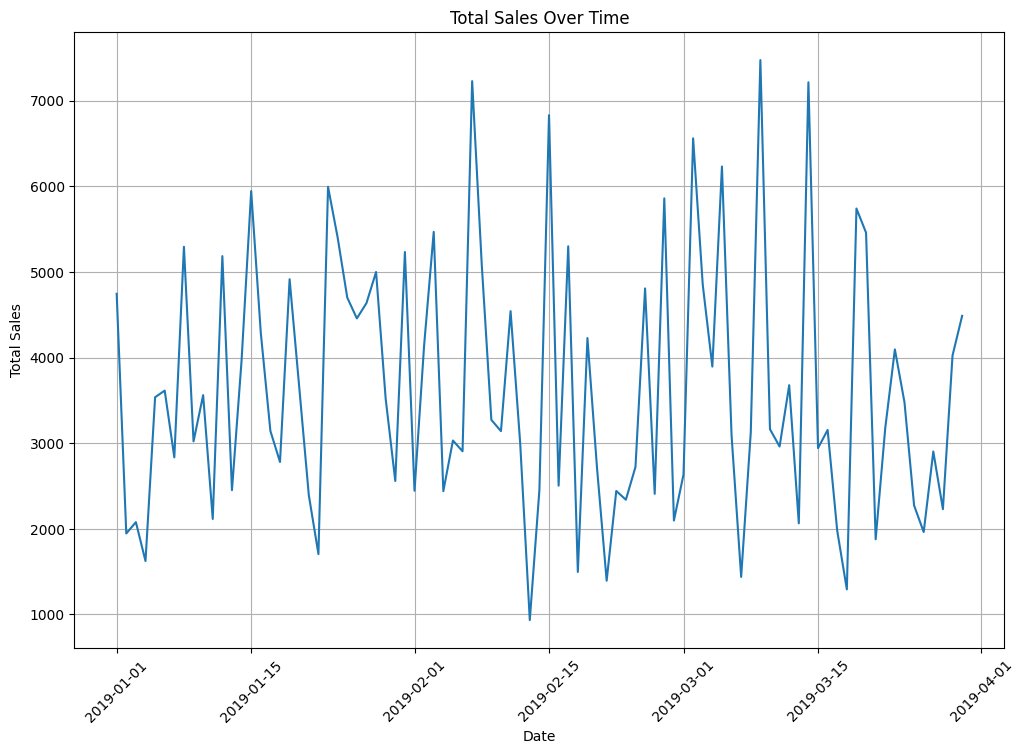

In [ ]:
# Load Dataset
file_path = "https://raw.githubusercontent.com/FinTrack-BangkitCapstone2024/MachineLearning/main/Dataset/supermarket_processed.csv"
df = pd.read_csv(file_path, parse_dates=['Date'])

# Sort the merged DataFrame by the 'date' column in ascending order
spm = df.sort_values(by='Date')

# Extracting dates and sales
time = np.array(spm['Date'])
series = np.array(spm['Total Sales'])

# Plot the filtered data
plot_series(spm['Date'], spm['Total Sales'], xlabel='Date', ylabel='Total Sales', title='Total Sales Over Time')

# Split Dataset

In [ ]:
ROW_COUNT = len(series)
SPLIT_TIME = int(0.7 * ROW_COUNT)

time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]

time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

# Features and Labels

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
WINDOW_SIZE = 7
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_set = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

# Build The Model

In [ ]:
model = tf.keras.models.Sequential([
    Conv1D(
        filters=16,
        kernel_size=3,
        activation="relu",
        padding='causal',
        input_shape=[WINDOW_SIZE, 1],
        kernel_regularizer=l2(0.001)
    ),
    LSTM(64, return_sequences=True, activation='relu'),
    LSTM(32, return_sequences=False, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 16)             64        
                                                                 
 lstm (LSTM)                 (None, 7, 64)             20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 33889 (132.38 KB)
Trainable params: 33889 

# Train the Model

In [ ]:
tf.keras.backend.clear_session()
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=["mae"])
history = model.fit(train_set, epochs=500, verbose=1)

Epoch 1/500
2/2 [==============================] - 4s 140ms/step - loss: 3958.8389 - mae: 3959.3372
Epoch 2/500
2/2 [==============================] - 0s 26ms/step - loss: 3709.3232 - mae: 3709.8215
Epoch 3/500
2/2 [==============================] - 0s 28ms/step - loss: 3556.5579 - mae: 3557.0562
Epoch 4/500
2/2 [==============================] - 0s 33ms/step - loss: 3477.0359 - mae: 3477.5342
Epoch 5/500
2/2 [==============================] - 0s 29ms/step - loss: 3394.9673 - mae: 3395.4656
Epoch 6/500
2/2 [==============================] - 0s 28ms/step - loss: 3460.7773 - mae: 3461.2756
Epoch 7/500
2/2 [==============================] - 0s 31ms/step - loss: 3474.5571 - mae: 3475.0554
Epoch 8/500
2/2 [==============================] - 0s 24ms/step - loss: 3480.6443 - mae: 3481.1426
Epoch 9/500
2/2 [==============================] - 0s 28ms/step - loss: 3444.7749 - mae: 3445.2732
Epoch 10/500
2/2 [==============================] - 0s 26ms/step - loss: 3387.8374 - mae: 3388.3357
Epoch 11

# Visualize Training Results

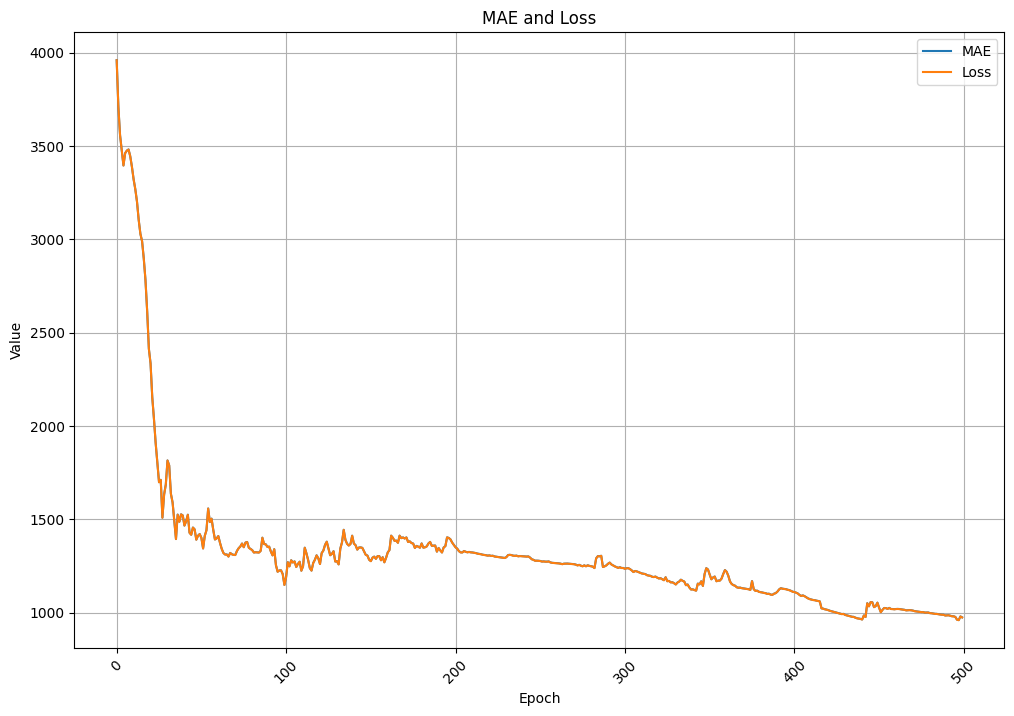

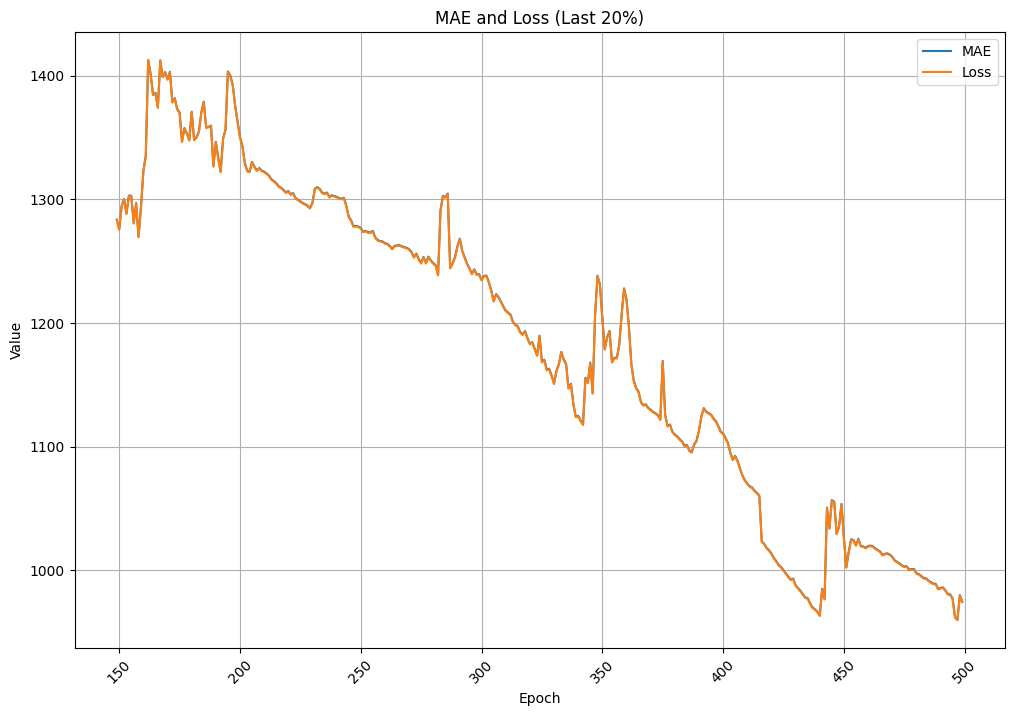

In [ ]:
mae = history.history['mae']
loss = history.history['loss']
epochs = range(len(loss))

plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='Epoch',
    ylabel='Value',
    legend=['MAE', 'Loss']
)

# Only plot the last 70% of the epochs
zoom_split = int(epochs[-1] * 0.3)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss (Last 20%)',
    xlabel='Epoch',
    ylabel='Value',
    legend=['MAE', 'Loss']
)

# Model Prediction

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

1/1 [==============================] - 0s 354ms/step


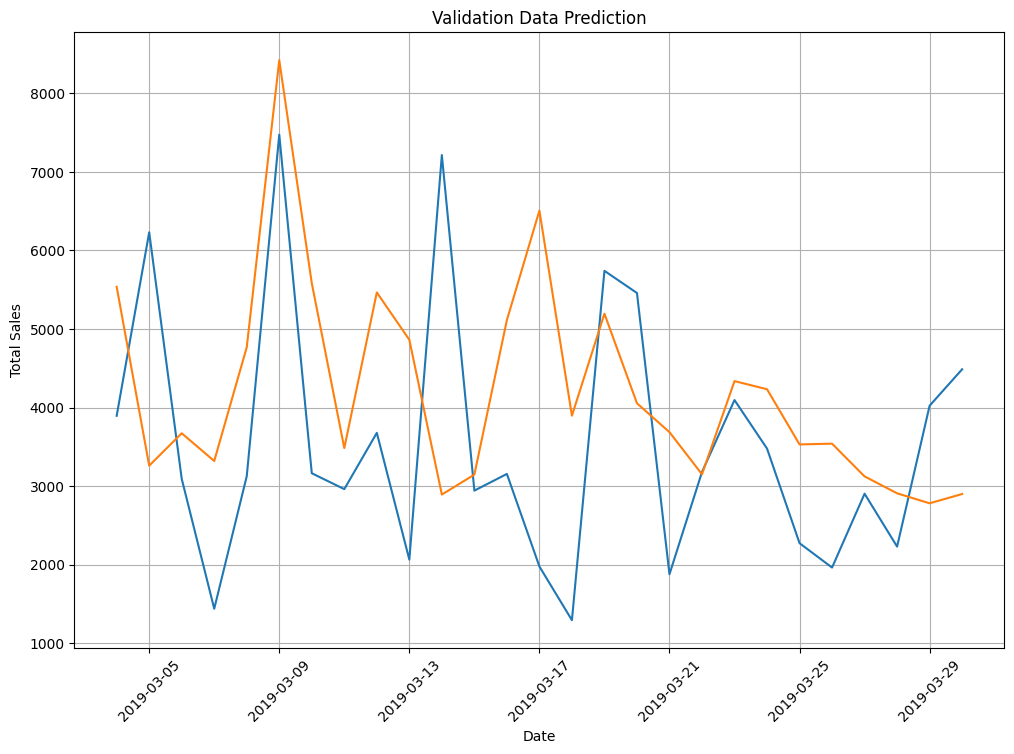

In [ ]:
forecast_series = series[SPLIT_TIME - WINDOW_SIZE: -1]
forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)
results = forecast.squeeze()

# Plot the validation data and predictions
plot_series(time_valid, (x_valid, results), xlabel='Date', ylabel='Total Sales', title='Validation Data Prediction')

3/3 [==============================] - 0s 28ms/step


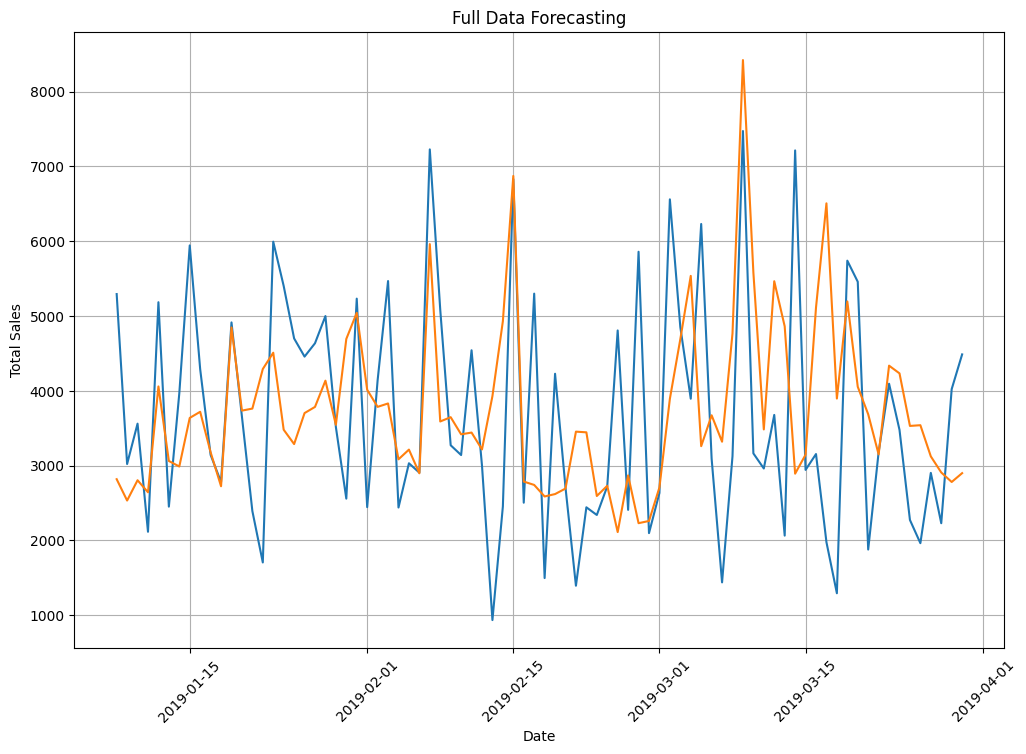

In [ ]:
# Plot the full time series and predictions
full_forecast_series = series[:-1]
full_forecast = model_forecast(model, full_forecast_series, WINDOW_SIZE, BATCH_SIZE)
full_results = full_forecast.squeeze()

plot_series(time[WINDOW_SIZE:], (series[WINDOW_SIZE:], full_results), xlabel='Date', ylabel='Total Sales', title='Full Data Forecasting')

# Save the Model

In [ ]:
model.save("ModelResult/model_supermarket.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
